# Proyecto 1, Modelos de Gestión Financiera
## Sebastian Puerto
## 25 de septiembre de 2019

# Punto 2

In [4]:
from simulador_S import grafico_valor_activo

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [22]:
def d1(S, t, E, r, sig, T):
    res = np.log(E/S) - (r + sig**2/2)*(T-t)
    res = res/( sig * np.sqrt(T-t) )
    
    return res

def d2(S, t, E, r, sig, T):
    res = np.log(E/S) - (r - sig**2/2)*(T-t)
    res = res/( sig * np.sqrt(T-t) )
    
    return res

def callV(S, t, E1, E2, r, sig, T):
    
    d1E1 = d1(S, T, E1, r, sig, T)
    d1E2 = d1(S, T, E2, r, sig, T)
    d2E1 = d2(S, T, E1, r, sig, T)
    d2E2 = d2(S, T, E2, r, sig, T)
    
    p1 = norm.cdf(d1E2) - norm.cdf(d1E1)
    
    p2 = norm.cdf(d2E2)- norm.cdf(d2E1)
    return S * p1  -  E1*np.exp(-r*(T-t)) * p2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


AttributeError: 'AxesSubplot' object has no attribute 'plot_surface'

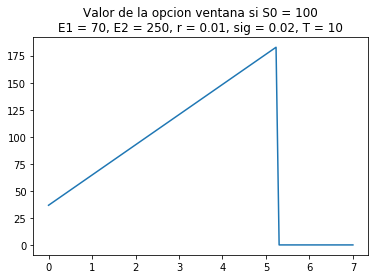

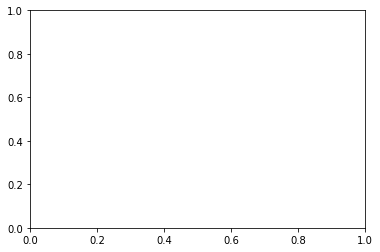

In [65]:
callV(S = 100, t = 20, E1 = 80, E2 = 200, r = 0.015, sig = 0.09, T = 100)

ts = np.linspace(0, 7, 100)
Ss = np.linspace(100, 300, 100)
#cs = callV(S = Ss, t = ts, E1 = 70, E2 = 250, r = 0.01, sig = 0.02, T = 10) # Funciona chevere
cs = callV(S = Ss, t = ts, E1 = 70, E2 = 300, r = 0.01, sig = 0.02, T = 10)

plt.figure()
plt.title("Valor de la opcion ventana si S0 = 100\nE1 = 70, E2 = 250, r = 0.01, sig = 0.02, T = 10")
plt.plot(ts, cs)

fig = plt.figure()
ts = np.linspace(0, 24, 200)
Ss = np.linspace(0, 300, 200)
Ts, Ss = np.meshgrid(ts, Ss)
Cs = callV(S = Ss, t = Ts, E1 = 80, E2 = 200, r = 0.015, sig = 0.09, T = 100)
#print(Cs)

ax = fig.gca()
ax.plot_surface(Ss, Ts, Cs)
plt.show()


# Calculo de Portafolios

In [85]:
def matriz_de(x, y, z):
    return  np.array([[x], [y], [z]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


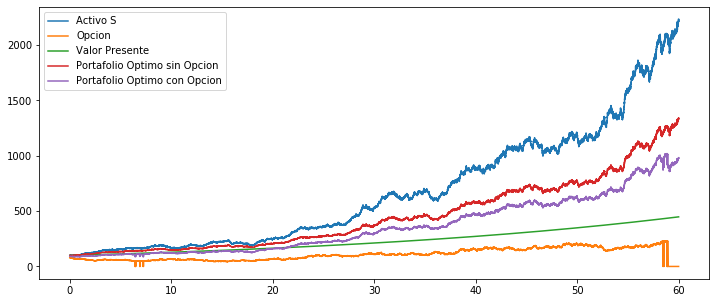

In [105]:
mmu = 0.03
ssig = 0.07

ts, Ss = grafico_valor_activo(mu = mmu, sig = ssig, S0 = 100, N = 60, txtad = "Sim. 1", graficar = False)
#ts, S2s = grafico_valor_activo(mu = mmu, sig = ssig, S0 = 100, N = 60, txtad = "Sim. 2", graficar = False)

Cs = callV(S = S1s, t = ts, E1 = 70, E2 = 300, r = mmu/1.5, sig = ssig, T = 60) # r = mu / 1.2
Ls = 100.*np.exp(mmu*ts/1.2)

portMej2 = matriz_de(0.5, 0.0, 0.5)
portMej3 = matriz_de(0.4, 0.4, 0.2)

musMej2 = portMej2[0,0]*Ss + portMej2[1,0]*Cs + portMej2[2,0]*Ls
musMej3 = portMej3[0,0]*Ss + portMej3[1,0]*Cs + portMej3[2,0]*Ls

fig = plt.figure(figsize=(12, 5))
plt.plot(ts, Ss)
plt.plot(ts, Cs)
plt.plot(ts, Ls)
plt.plot(ts, musMej2)
plt.plot(ts, musMej3)

plt.legend(("Activo S", "Opcion", "Valor Presente", 
            "Portafolio Optimo sin Opcion", "Portafolio Optimo con Opcion"), loc = "upper left")

In [77]:
#mus  = np.array([0.001, 0.005, 0.015, 0.03])
mus = [0.015, 0.03]
#sigs = [0.01, 0.05, 0.09, 0.15]
sigs = [0.09]

portss = [[1., 0, 0], [0, 1., 0], [0, 0, 1.], [0.5, 0.5, 0], [0.4, 0.4, 0.2]]

MU = 0.03
SIG = 0.09

rendsMej3 = []
rendsMej2 = []

for mmu in mus:
    for ssig in sigs:
        ts, S1s = grafico_valor_activo(mu = mmu, sig = ssig, S0 = 100, N = 60, txtad = "Sim. 1", graficar = False, pts = 60)
        ts, S2s = grafico_valor_activo(mu = mmu, sig = ssig, S0 = 100, N = 60, txtad = "Sim. 2", graficar = False, pts = 60)
        
        C1s = callV(S = S1s, t = ts, E1 = 70, E2 = 300, r = mmu/1.2, sig = ssig, T = 60) # r = mu / 1.2
        C2s = callV(S = S2s, t = ts, E1 = 70, E2 = 300, r = mmu/1.2, sig = ssig, T = 60)
        
        Ls = 100.*np.exp(ts)
        
        portMej2 = np.array([[0.5], [0.0], [0.5]])
        portMej3 = np.array([[0.5], [0.3], [0.2]])
        #print(np.shape(portMej2))
        
        if  (mmu == MU and ssig == SIG):
            fig = plt.figure()
        
        Sf = S1s[-1]
        Cf = C1s[-1]
        Lf = Ls[-1]
        rendsMej2.append((portMej2[0,0]*Sf + portMej2[1,0]*Cf + portMej2[2,0]*Lf)/100)
        rendsMej3.append((portMej3[0,0]*Sf + portMej3[1,0]*Cf + portMej3[2,0]*Lf)/100)
        
        Sf = S2s[-1]
        Cf = C2s[-1]
        Lf = Ls[-1]
        rendsMej2.append((portMej2[0,0]*Sf + portMej2[1,0]*Cf + portMej2[2,0]*Lf)/100)
        rendsMej3.append((portMej3[0,0]*Sf + portMej3[1,0]*Cf + portMej3[2,0]*Lf)/100)
        
rendsMej2 = np.array(rendsMej2)
rendsMej3 = np.array(rendsMej3)

ratio = rendsMej2/rendsMej3
print(ratio)
        
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


(3, 1)
(3, 1)
[2.5 2.5 2.5 2.5]


<Figure size 432x288 with 0 Axes>